## Multi-Headed Output
The following Code contains the multi-headed output CNN for 6 classes. At the very end is a test with fine-tuning a pre-trained Resnet to also act as a comparison. Losses curves at the end show overall performance, with the mulit-headed CNN model still getting promising results, despite Resnet still outperforming in loss minimization.

## Data Setup

### Mount your google drive (might have to change directory here for your google drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Packages

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import os
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
import PIL.Image as Image
from sklearn.model_selection import train_test_split

### Dataset Download

In [ ]:
class ProjPointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file_id, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.landmarks_frame = pd.read_csv(csv_file)
        #self.landmarks_frame = csv_file
        self.landmarks_id = csv_file_id
        #self.landmarks_id = self.landmarks_id_df['id']
        self.root_dir = root_dir
        self.transform = transform
        self.landmarks_df = pd.read_csv(csv_file)
        #self.database = []
        #for i in range(len(landmarks_id)):


        #self.database.append(sample)


    def __len__(self):
        return len(self.landmarks_id)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()
      #print(type(self.landmarks_id))
      img_name = os.path.join(self.root_dir, self.landmarks_id.iloc[idx,0])
      img_name = img_name + '.png'
      image = io.imread(img_name)
      landmarks = self.landmarks_df[self.landmarks_df['id'] == self.landmarks_id.iloc[idx,0]][['x', 'y']].values
      landmarks[:,1] = 1000 - landmarks[:,1]
      landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
      sample = {'image': image, 'landmarks': landmarks}


      if self.transform:
        sample = self.transform(sample)

      return sample

### Get Directories

In [ ]:
landmarks_id_dir = '/content/drive/MyDrive/side-notchedLandmarks-only_class1.csv'
landmarks_id_df = pd.read_csv(landmarks_id_dir)

image_directory = '/content/drive/MyDrive/landmarkTraining'
landmarks_dir = '/content/drive/MyDrive/side-notchedLandmarks_123456.csv'

## Image Dataset tests

### Plot Landmarks test

In [ ]:
pp_db = ProjPointsDataset(landmarks_id_df, landmarks_dir, image_directory)

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    print("Image type: ", type(image))
    plt.imshow(image)

    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

0 (1000, 1000, 4) (6, 2)
Image type:  <class 'numpy.ndarray'>


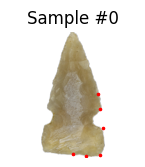

1 (1000, 1000, 4) (6, 2)
Image type:  <class 'numpy.ndarray'>


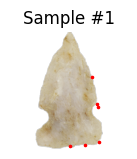

2 (1000, 1000, 4) (6, 2)
Image type:  <class 'numpy.ndarray'>


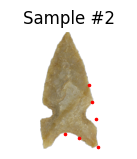

3 (1000, 1000, 4) (6, 2)
Image type:  <class 'numpy.ndarray'>


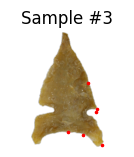

In [ ]:
fig = plt.figure()

for i, sample in enumerate(pp_db):
    print(i, sample['image'].shape, sample['landmarks'].shape)
    #print(i, sample['image'].size, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## Rescale Function

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W

        image = image.transpose((2, 0, 1))
        ### Grab only first 3 input channels of image, as fourth channel is a "transparency" channel
        #print("Image shape: ", image[0:3].shape)
        return {'image': torch.from_numpy(image[0:3]),
                'landmarks': torch.from_numpy(landmarks)}

Image type:  <class 'numpy.ndarray'>


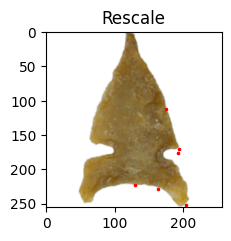

Image type:  <class 'numpy.ndarray'>


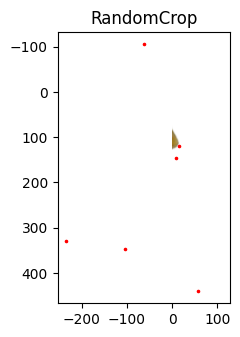

Image type:  <class 'numpy.ndarray'>


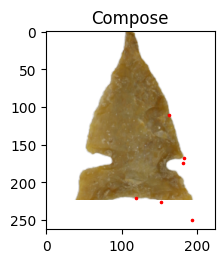

In [ ]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = pp_db[3]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Accuracy Function

In [ ]:
def accuracy(predicted, actual):
  threshhold = .2
  diff = torch.sub(actual,predicted,alpha=1,out=None)
  #print(diff)

  a = torch.norm(diff, p=float('inf'),dim=1)
  #print("a: ", a)
  accur_score = a < threshhold
  #print(accur_score)
  return torch.mean(accur_score.float())


## 6 class Test

### Train/Test split

In [ ]:
train_landmarks, test_landmarks = train_test_split(landmarks_id_df, test_size=0.2)

### Train loop setup

In [ ]:
landmarks_dir_6class = '/content/drive/MyDrive/side-notchedLandmarks_123456.csv'

train_data6 = ProjPointsDataset(train_landmarks,landmarks_dir_6class, image_directory, transform=transforms.Compose([
                                               Rescale(256),
                                               #RandomCrop(224),
                                               ToTensor()]))
val_data6 = ProjPointsDataset(test_landmarks,landmarks_dir_6class, image_directory, transform=transforms.Compose([
                                               Rescale(256),
                                               #RandomCrop(224),
                                               ToTensor()]))

In [ ]:
class ConvNetwork_vector_6class(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork_vector_6class, self).__init__()
    rescale_factor = 256
    x, y = dataset[0]
    c = 3
    h = rescale_factor
    w = rescale_factor
    #output = 10
###
    self.net = nn.Sequential(
        nn.Conv2d(c, 36, (11, 11)),
        nn.ReLU(),
        # ##nn.Softmax(dim=1),
        nn.Conv2d(36, 64, (21, 21)),
        nn.ReLU(),
        nn.MaxPool2d(2, stride =  1),
        nn.Conv2d(64, 128, (101, 101)),
        # #nn.Linear(24, output)
        nn.LeakyReLU(0.1),
        nn.Conv2d(128, 64, (101, 101)),
        nn.ReLU(),
        nn.Conv2d(64, 36, (24, 24)),
        nn.ReLU(),
        nn.MaxPool2d(2, stride =  1)
    )

    self.linear_end_1 = nn.Sequential(
        nn.Linear(36, 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,2)
    )
    self.linear_end_2 = nn.Sequential(
        nn.Linear(36, 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,2)
    )
    self.linear_end_3 = nn.Sequential(
        nn.Linear(36, 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,2)
    )
    self.linear_end_4 = nn.Sequential(
        nn.Linear(36, 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,2)
    )
    self.linear_end_5 = nn.Sequential(
        nn.Linear(36, 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,2)
    )
    self.linear_end_6 = nn.Sequential(
        nn.Linear(36, 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,2)
    )
        ### change shape of x

  def forward(self, x):
    #return self.net(x).squeeze(2).squeeze(2)
    x_1 = self.net(x)
    x_1 = x_1.view(x_1.size(0),-1)
    #print("x_1: ", x_1.size())
    x_2_1 = self.linear_end_1(x_1)
    x_2_2 = self.linear_end_2(x_1)
    x_2_3 = self.linear_end_3(x_1)
    x_2_4 = self.linear_end_4(x_1)
    x_2_5 = self.linear_end_5(x_1)
    x_2_6 = self.linear_end_6(x_1)
    return torch.cat((x_2_1,x_2_2,x_2_3,x_2_4,x_2_5,x_2_6),1)


In [ ]:
import gc

def training_multi_class(class_num, input_model, train_data_input, val_data_input):

    gc.collect()
    epochs = 5
    rescale = 256
    lr = .05
    val_every = 10
    reshape_val = class_num*2

    batch_size = 10
    device = torch.device('cuda:0')
    model = input_model
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    objective = nn.MSELoss()

    train_dataloader = DataLoader(train_data_input, batch_size=batch_size,
                            shuffle=True, num_workers=5)

    val_dataloader = DataLoader(val_data_input, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    losses = []
    validations = []
    val_accuracies = []
    accuracies = []
    #batch = 0

    for epoch in range(epochs):
      loop = tqdm(total=len(train_dataloader), position=0, leave=False)
      for item in train_dataloader:
        ### for garbage collection

        x = item['image']
        x = x.float()
        x = x/rescale
        #print("Type: ", x.dtype)
        y_truth = item['landmarks']
        #print("Type: ",y_truth.dtype)
        y_truth = y_truth.float()
        y_truth = y_truth/rescale


        x, y_truth = x.to(device), y_truth.to(device)
        #print ("Y_truth: ", y_truth)
        optimizer.zero_grad()
        #print(x.size())
        y_hat = model(x)
        #y_hat = return_linlay_res(y_init)
        y_hat = y_hat.float()
        #print(y_hat)
        ## loss = euclidean_loss(y_hat, y_truth)
        # print(y_hat.size())
        # print(y_truth.size())
        y_truth = y_truth.squeeze(1)
        #y_truth = torch.cat((y_truth), 0)
        # print("y_truth: ", y_truth.size())

        # print("y_truth: ", y_truth.size())
        # print("batch_size: ", y_truth.size(0))
        curr_batch = y_truth.size(0)
        #print("y_hat: ", y_hat.size())
        y_truth = y_truth.view((curr_batch, reshape_val))

        # print("y_truth: ", y_truth.size())
        # print("y_hat: ", y_hat.size())
        loss = objective(y_hat, y_truth)
        loss.backward()
        losses.append(loss.item())

        output_accuracy = accuracy(y_hat, y_truth)
        accuracies.append(output_accuracy.item())

        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss.item(), output_accuracy.item()))
        loop.update(1)

        optimizer.step()

        ##batch += 1
        ###if batch % 40 == 0:

        del loss
        del x, y_truth
        del y_hat
        torch.cuda.empty_cache()
      #### End inner train loop
      ### for every epoch do val collection
      with torch.no_grad():
        vals = []
        acc_vals = []
        for item in val_dataloader:
          x = item['image']
          x = x.float()
          x = x/rescale

          y = item['landmarks']
          y = y.float()
          y = y/rescale
          y = y.squeeze(1)
          curr_val_batch = y.size(0)
          y = y.view((curr_val_batch,reshape_val))

          val = np.mean([objective(model(x.cuda()), y.cuda()).item()])
          vals.append(val)

          val_acc = np.mean([accuracy(model(x.cuda()), y.cuda()).item()])
          acc_vals.append(val_acc)
          del x,y
          torch.cuda.empty_cache()
        validations.append((len(losses),  np.mean(vals)))

        val_accuracies.append((len(accuracies), np.mean(acc_vals)))

    return losses, validations, accuracies, val_accuracies

In [ ]:
losses_returned_6class, val_returned_6class, acc_6class, val_acc_6class = training_multi_class(6, ConvNetwork_vector_6class(train_data6), train_data6, val_data6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/43 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goin

In [ ]:
print("Losses: ",losses_returned_6class)
print("Val losses: ", val_returned_6class)
print("Accuracies: ", acc_6class)
print("Val Accuracies: ", val_acc_6class)

Losses:  [0.5046002864837646, 0.5108722448348999, 0.48887398838996887, 0.40048345923423767, 0.6898079514503479, 0.32072144746780396, 0.43337690830230713, 0.4943583309650421, 0.4763638973236084, 0.4447095990180969, 0.34507182240486145, 0.24114444851875305, 0.40762561559677124, 0.2392093539237976, 0.20999523997306824, 0.25300881266593933, 0.26194798946380615, 0.2332378476858139, 0.19978050887584686, 0.15513655543327332, 0.15506596863269806, 0.14967910945415497, 0.1372710019350052, 0.09813237935304642, 0.10498740524053574, 0.07915179431438446, 0.05778515338897705, 0.068646639585495, 0.049697145819664, 0.0437636598944664, 0.05610052868723869, 0.039056446403265, 0.03116212785243988, 0.03172216936945915, 0.026126019656658173, 0.02369486540555954, 0.018411360681056976, 0.020503932610154152, 0.01590714417397976, 0.015991859138011932, 0.010563960298895836, 0.011875891126692295, 0.008022699505090714, 0.0064659519121050835, 0.009098438546061516, 0.0064321705140173435, 0.0074971201829612255, 0.006

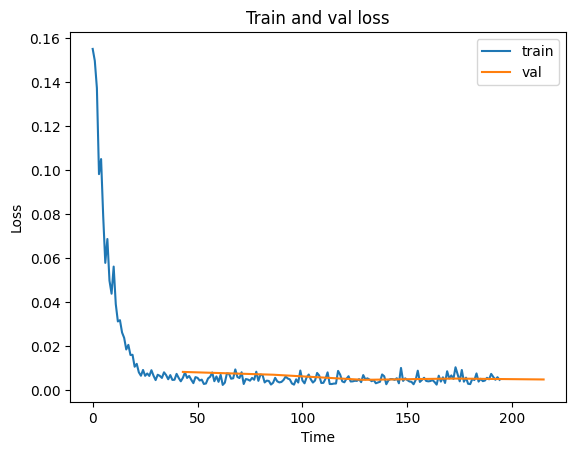

In [ ]:
a,b = zip(*val_returned_6class)
plt.title("Train and val loss")
plt.plot(losses_returned_6class[20:], label='train')
plt.plot(a,b, label='val')
plt.xlabel("Time")
plt.ylabel("Loss")
plt.legend()
plt.show()

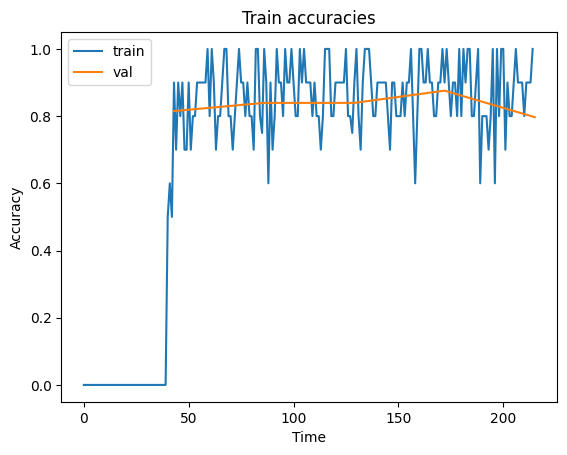

In [ ]:
a,b = zip(*val_acc_6class)
plt.title("Train accuracies")
plt.plot((acc_6class), label='train')
plt.plot(a,b, label='val')
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
final_model =  ConvNetwork_vector_6class(train_data6)

total_params = sum(p.numel() for p in final_model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 169545440


## Resnet Fine-Tuning Model

In [ ]:
from torchvision.models import resnet152

In [ ]:
train_data6 = ProjPointsDataset(train_landmarks, landmarks_dir, image_directory, transform=transforms.Compose([
                                               Rescale(256),
                                               #RandomCrop(224),
                                               ToTensor()]))
val_data6 = ProjPointsDataset(test_landmarks, landmarks_dir, image_directory, transform=transforms.Compose([
                                               Rescale(256),
                                               #RandomCrop(224),
                                               ToTensor()]))

In [ ]:
model_res = resnet152(pretrained=True)
linlay_in_feat = model_res.fc.in_features
model_res.fc = nn.Linear(linlay_in_feat, 2)

model_res.fc = nn.Sequential(
        nn.Linear(linlay_in_feat, 100),
        nn.ReLU(),
        nn.Linear(100,70),
        nn.ReLU(),
        nn.Linear(70,40),
        nn.ReLU(),
        nn.Linear(40,12))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 84.1MB/s]


In [ ]:
import gc

def training_multi_class(input_model,class_num, input_train_data, input_val_data):

    gc.collect()
    epochs = 5
    rescale = 256
    lr = .005
    val_every = 10
    reshape_val = class_num*2

    batch_size = 10
    device = torch.device('cuda:0')

    model = input_model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    objective = nn.MSELoss()

    train_dataloader = DataLoader(input_train_data, batch_size=batch_size,
                            shuffle=True, num_workers=5)

    val_dataloader = DataLoader(input_val_data, batch_size=batch_size,
                            shuffle=True, num_workers=0)
    losses = []
    validations = []
    val_accuracies = []
    accuracies = []
    #batch = 0

    for epoch in range(epochs):
      loop = tqdm(total=len(train_dataloader), position=0, leave=False)
      for item in train_dataloader:
        ### for garbage collection

        x = item['image']
        x = x.float()
        x = x/rescale
        #print("Type: ", x.dtype)
        y_truth = item['landmarks']
        #print("Type: ",y_truth.dtype)
        y_truth = y_truth.float()
        y_truth = y_truth/rescale


        x, y_truth = x.to(device), y_truth.to(device)
        #print ("Y_truth: ", y_truth)
        optimizer.zero_grad()
        #print(x.size())
        y_hat = model(x)
        #y_hat = return_linlay_res(y_init)
        y_hat = y_hat.float()
        #print(y_hat)
        ## loss = euclidean_loss(y_hat, y_truth)
        # print(y_hat.size())
        # print(y_truth.size())
        y_truth = y_truth.squeeze(1)
        #y_truth = torch.cat((y_truth), 0)
        #print("y_truth: ", y_truth)

        # print("y_truth: ", y_truth.size())
        # print("batch_size: ", y_truth.size(0))
        curr_batch = y_truth.size(0)
        # print("y_hat: ", y_hat.size())
        y_truth = y_truth.view((curr_batch, reshape_val))
        #print("y_truth: ", y_truth.size())

        # print("y_truth: ", y_truth.size())
        # print("y_hat: ", y_hat.size())
        loss = objective(y_hat, y_truth)
        loss.backward()
        losses.append(loss.item())

        output_accuracy = accuracy(y_hat, y_truth)
        accuracies.append(output_accuracy.item())

        loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
        loop.update(1)

        optimizer.step()

        ##batch += 1
        ###if batch % 40 == 0:

        del loss
        del x, y_truth
        del y_hat
        torch.cuda.empty_cache()
      #### End inner train loop
      ### for every epoch do val collection
      with torch.no_grad():
        vals = []
        acc_vals = []
        for item in val_dataloader:
          x = item['image']
          x = x.float()
          x = x/rescale

          y = item['landmarks']
          y = y.float()
          y = y/rescale
          y = y.squeeze(1)
          curr_val_batch = y.size(0)
          y = y.view((curr_val_batch,reshape_val))

          # val = np.mean([objective(model(x.cuda()), y.cuda()).item()])
          # validations.append((len(losses), val))

          val = np.mean([objective(model(x.cuda()), y.cuda()).item()])
          vals.append(val)

          val_acc = np.mean([accuracy(model(x.cuda()), y.cuda()).item()])
          acc_vals.append(val_acc)
          del x,y
          torch.cuda.empty_cache()
        validations.append((len(losses),  np.mean(vals)))

        val_accuracies.append((len(accuracies), np.mean(acc_vals)))

    return losses, validations, accuracies, val_accuracies

In [ ]:
losses_returned_6class, val_returned_6class, acc_6ret, acc_val6ret = training_multi_class(model_res, 6, train_data6, val_data6)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/43 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is goin

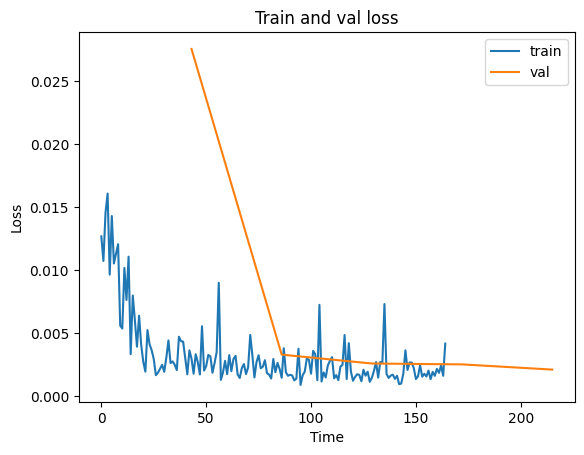

In [ ]:
a,b = zip(*val_returned_6class)
plt.title("Train and val loss")
plt.plot(losses_returned_6class[50:], label='train')
plt.plot(a,b, label='val')
plt.xlabel("Time")
plt.ylabel("Loss")
plt.legend()
plt.show()

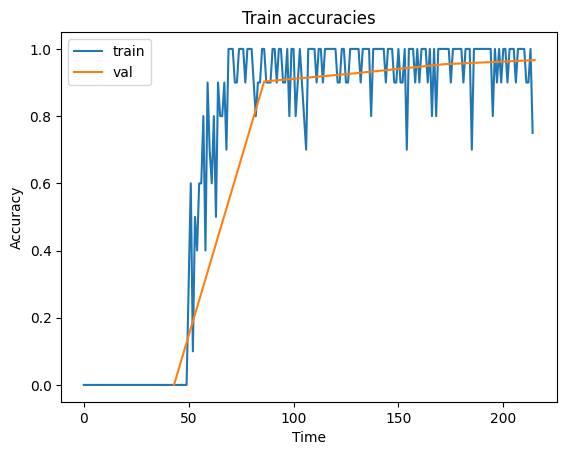

In [ ]:
a,b = zip(*acc_val6ret)
plt.title("Train accuracies")
plt.plot((acc_6ret), label='train')
plt.plot(a,b, label='val')
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()
plt.show()